In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import random
import os
import re
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Breathing Rate - Savitzy Golay and Moving Average

NameError: name 'save_dir' is not defined

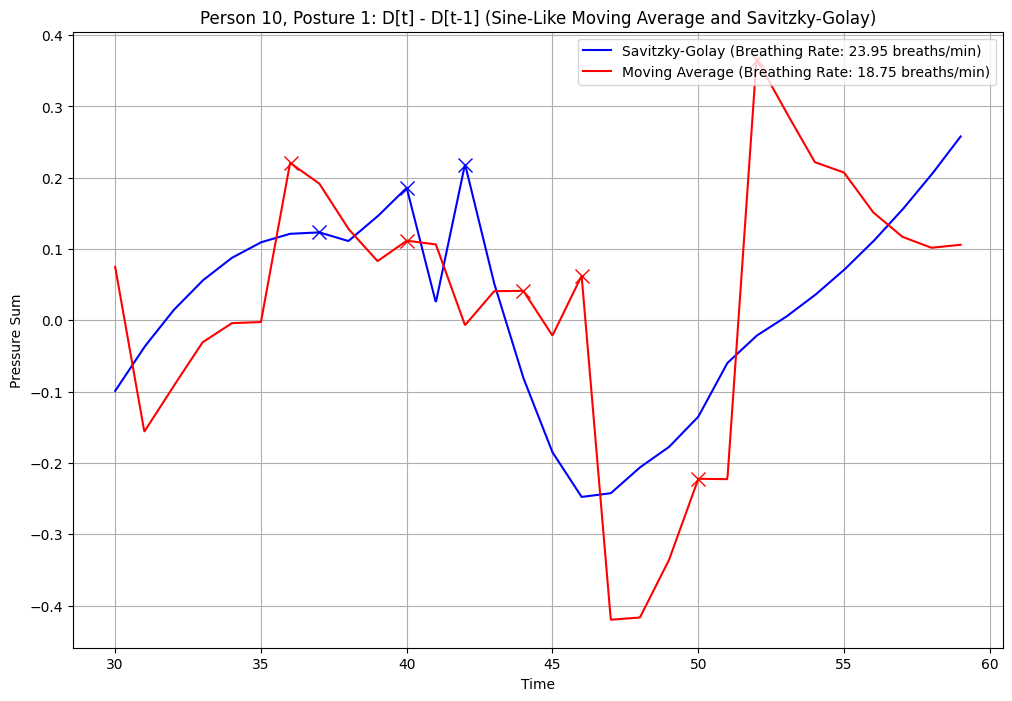

In [ ]:
import numpy as np
import pandas as pd
from scipy import interpolate
from scipy.signal import find_peaks, savgol_filter
import matplotlib.pyplot as plt

def calculate_breathing_rate(y_smooth, x_new):
    peaks, _ = find_peaks(y_smooth)
    if len(peaks) > 1:
        peak_diffs = np.diff(x_new[peaks])
        average_peak_diff = np.mean(peak_diffs)
        breathing_rate = 60 / average_peak_diff  # Breaths per minute
        return breathing_rate, peaks
    return None, peaks
# Define the specific subject and posture
PERSON = 10  # Subject 3
POSTURE = 1  # Posture 1

# File path for Subject 3, Posture 1
path = f"/content/drive/Shareddrives/Project Sleep/PMD/experiment-i/S{PERSON}/{POSTURE}.txt"

# Read the data into a DataFrame
df = pd.read_csv(path, sep='\t', header=None)

# Subtract previous row from each row
df = df.sub(df.shift(1), fill_value=0)
row_sums = df.iloc[30:60, :768].mean(axis=1)

# Define X-axis values
x = np.arange(30, 30 + len(row_sums))

# Interpolation and Smoothing Methods
methods = {}

# Method 3: Savitzky-Golay Smoothing with adjusted window length and polynomial order for smoother curve
y_smooth_savgol = savgol_filter(row_sums, window_length=15, polyorder=2)  # Increased window length to 15 for more smoothing
x_new = np.linspace(30, 30 + len(row_sums) - 1, 50 * len(row_sums))  # Finer X-axis interpolation for smoother curve
methods["Savitzky-Golay"] = np.interp(x_new, x, y_smooth_savgol)

# Method 4: Moving Average Smoothing with a larger window size for better smoothing
window_size = 5  # Increase window size for smoother averaging
y_smooth_moving_avg = np.convolve(row_sums, np.ones(window_size) / window_size, mode='same')
methods["Moving Average"] = np.interp(x_new, x, y_smooth_moving_avg)

# Plotting only Moving Average and Savitzky-Golay methods
plt.figure(figsize=(12, 8))
colors = ['blue', 'red']
breathing_rates = {}

for i, (method_name, y_smooth) in enumerate(methods.items()):
    breathing_rate, peaks = calculate_breathing_rate(y_smooth, x_new)
    breathing_rates[method_name] = breathing_rate
    # Plot each method's result
    plt.plot(x_new, y_smooth, label=f'{method_name} (Breathing Rate: {breathing_rate:.2f} breaths/min)', color=colors[i])
    # Plot peaks
    if len(peaks) > 0:
        plt.plot(x_new[peaks], y_smooth[peaks], "x", markersize=10, color=colors[i])

# Plot configurations
plt.title(f'Person {PERSON}, Posture {POSTURE}: D[t] - D[t-1] (Sine-Like Moving Average and Savitzky-Golay)')
plt.xlabel('Time')
plt.ylabel('Pressure Sum')
plt.grid(True)
plt.legend(loc='upper right')

# Save plot as PNG in the specified directory
plot_filename = f"Breathing_Rate_Person_{PERSON}_Posture_{POSTURE}_Sine_Like.png"
plt.savefig(os.path.join(save_dir, plot_filename))
plt.close()  # Close the plot to avoid memory overload

# Output the average breathing rates for the two methods
for method, rate in breathing_rates.items():
    print(f"Breathing Rate using {method}: {rate:.2f} breaths/min")



## Breathing Rate Estimation


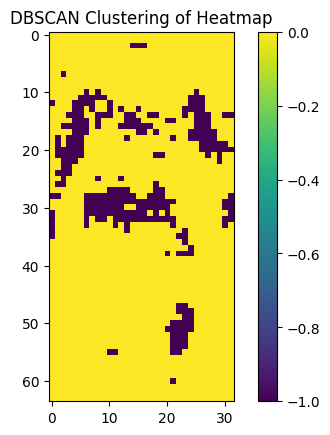

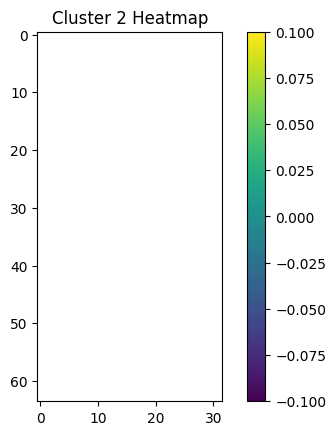

In [ ]:
PERSON = 7

path = f"/content/drive/Shareddrives/Project Sleep/PMD/experiment-i/S{PERSON}/1.txt"

# Read the data into a DataFrame
df = pd.read_csv(path, sep='\t', header=None).iloc[:, :-1]
frame_image = df.iloc[30].values.reshape(64, 32)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Example: Create a synthetic heatmap (you would load your actual heatmap data here)
heatmap = df.iloc[30].values.reshape(64, 32) # Replace with your heatmap data

# Normalize the heatmap data
scaler = StandardScaler()
heatmap_normalized = scaler.fit_transform(heatmap)

# Reshape the data for clustering
data_for_clustering = heatmap_normalized.reshape(-1, 1)

# Apply DBSCAN clustering
eps = 0.3# Set the epsilon value
min_samples = 200  # Set the minimum number of samples

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan.fit(data_for_clustering)

# Get the cluster labels
labels = dbscan.labels_
labels = labels.reshape(heatmap.shape)  # Reshape to the original heatmap shape

# Visualize the clustered heatmap
plt.imshow(labels, cmap='viridis')  # Use a colormap of your choice
plt.colorbar()
plt.title('DBSCAN Clustering of Heatmap')
plt.show()



Time Series Analysis - breathing rate (Linear Interpolation)

[2.42474916 3.39464883 3.2006689  2.909699   3.00668896 2.6187291
 4.36454849 1.93979933]


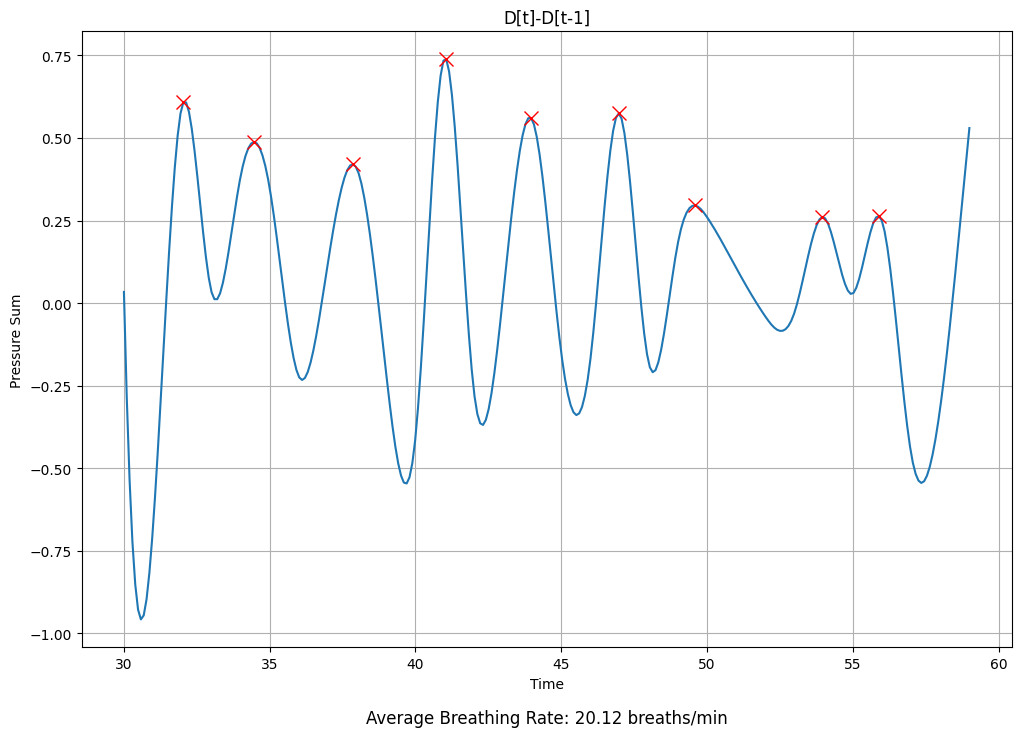

In [ ]:
from scipy import interpolate
from scipy.signal import find_peaks

PERSON = 3
POSTURE=1
path = f"/content/drive/Shareddrives/Project Sleep/PMD/experiment-i/S{PERSON}/{POSTURE}.txt"

# Read the data into a DataFrame
df = pd.read_csv(path, sep='\t', header=None)

# Subtract previous row from each row
df = df.sub(df.shift(1), fill_value=0)E
row_sums = df.iloc[30:60, :768].mean(axis=1)

# Interpolate to make the curve look continuous
x = np.arange(30, 30 + len(row_sums))  # X-axis values
f = interpolate.interp1d(x, row_sums, kind='cubic')
x_new = np.linspace(30, 30 + len(row_sums) - 1, 10 * len(row_sums))  # New X-axis values with increased density
y_smooth = f(x_new)

peaks, _ = find_peaks(y_smooth)
peak_diffs = np.diff(x_new[peaks])
print(peak_diffs)

# Calculate the average difference between peaks
average_peak_diff = np.mean(peak_diffs)

breathing_rate = 60 / average_peak_diff  # Breaths per minute

# Plot how the sum changes through the rows with magnification and smoothing
plt.figure(figsize=(12, 8))
plt.plot(x_new, y_smooth)
plt.plot(x_new[peaks], y_smooth[peaks], "x", markersize=10, color='red')
plt.title('D[t]-D[t-1]')
plt.xlabel('Time')
plt.ylabel('Pressure Sum')
plt.grid(True)

# Add text annotation for breathing rate below the plot
plt.text(0.5, -0.1, f'Average Breathing Rate: {breathing_rate:.2f} breaths/min', transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', horizontalalignment='center', backgroundcolor='white')

plt.show()


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.signal import find_peaks

# List of subjects and postures to process
subjects = range(1, 18)  # From 1 to 17
postures = [1, 8, 9, 10, 11, 12, 15, 16, 17]

# Directory to save the plots
output_dir = '/content/drive/Shareddrives/Project Sleep/Breathing_Rate_Plots'
os.makedirs(output_dir, exist_ok=True)

# List to store average breathing rates
avg_breathing_rates = []

# Loop through each subject and posture
for person in subjects:
    for posture in postures:
        try:
            # Path to the file for each person and posture
            path = f"/content/drive/Shareddrives/Project Sleep/PMD/experiment-i/S{person}/{posture}.txt"

            # Read the data into a DataFrame
            df = pd.read_csv(path, sep='\t', header=None)

            # Subtract previous row from each row
            df = df.sub(df.shift(1), fill_value=0)

            # Calculate row sums for rows 30 to 60 and the first 768 columns
            row_sums = df.iloc[30:60, :768].mean(axis=1)

            # Interpolate to make the curve look continuous
            x = np.arange(30, 30 + len(row_sums))  # X-axis values
            f = interpolate.interp1d(x, row_sums, kind='cubic')
            x_new = np.linspace(30, 30 + len(row_sums) - 1, 10 * len(row_sums))  # New X-axis values with increased density
            y_smooth = f(x_new)

            # Find peaks in the smoothed data
            peaks, _ = find_peaks(y_smooth)
            peak_diffs = np.diff(x_new[peaks])

            # Calculate the average difference between peaks and the breathing rate
            average_peak_diff = np.mean(peak_diffs)
            breathing_rate = 60 / average_peak_diff  # Breaths per minute

            # Store the breathing rate in the list
            avg_breathing_rates.append((person, posture, breathing_rate))

            # Plot the smoothed data and mark the peaks
            plt.figure(figsize=(12, 8))
            plt.plot(x_new, y_smooth)
            plt.plot(x_new[peaks], y_smooth[peaks], "x", markersize=10, color='red')
            plt.title(f'Person {person}, Posture {posture}: D[t]-D[t-1]')
            plt.xlabel('Time')
            plt.ylabel('Pressure Sum')
            plt.grid(True)

            # Add text annotation for breathing rate below the plot
            plt.text(0.5, -0.1, f'Average Breathing Rate: {breathing_rate:.2f} breaths/min',
                     transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
                     horizontalalignment='center', backgroundcolor='white')

            # Save the plot to the specified directory
            output_path = os.path.join(output_dir, f'Breathing_Rate_Person_{person}_Posture_{posture}.png')
            plt.savefig(output_path)
            plt.close()

        except Exception as e:
            print(f"Error processing Person {person}, Posture {posture}: {e}")

# Print or save the average breathing rates list as needed
print(avg_breathing_rates)


Error processing Person 14, Posture 1: [Errno 2] No such file or directory: '/content/drive/Shareddrives/Project Sleep/PMD/experiment-i/S14/1.txt'
Error processing Person 14, Posture 8: [Errno 2] No such file or directory: '/content/drive/Shareddrives/Project Sleep/PMD/experiment-i/S14/8.txt'
Error processing Person 14, Posture 9: [Errno 2] No such file or directory: '/content/drive/Shareddrives/Project Sleep/PMD/experiment-i/S14/9.txt'
Error processing Person 14, Posture 10: [Errno 2] No such file or directory: '/content/drive/Shareddrives/Project Sleep/PMD/experiment-i/S14/10.txt'
Error processing Person 14, Posture 11: [Errno 2] No such file or directory: '/content/drive/Shareddrives/Project Sleep/PMD/experiment-i/S14/11.txt'
Error processing Person 14, Posture 12: [Errno 2] No such file or directory: '/content/drive/Shareddrives/Project Sleep/PMD/experiment-i/S14/12.txt'
Error processing Person 14, Posture 15: [Errno 2] No such file or directory: '/content/drive/Shareddrives/Projec

Average breathing rate for all subjects in all supine postures.

In [ ]:
POSTURES=[1,8,9,10,11,12,15,16,17]
breathing_rates=[]
for PERSON in range(1,14):
  for POSTURE in POSTURES:
      path = f"/content/drive/Shareddrives/Project Sleep/PMD/experiment-i/S{PERSON}/{POSTURE}.txt"

      # Read the data into a DataFrame
      df = pd.read_csv(path, sep='\t', header=None)

      # Subtract previous row from each row
      df = df.sub(df.shift(1), fill_value=0)
      row_sums = df.iloc[30:60, :768].mean(axis=1)

      # Interpolate to make the curve look continuous
      x = np.arange(30,30 + len(row_sums))  # X-axis values
      f = interpolate.interp1d(x, row_sums, kind='cubic')
      x_new = np.linspace(30, 30 + len(row_sums) - 1, 10 * len(row_sums))  # New X-axis values with increased density
      y_smooth = f(x_new)

      peaks, _ = find_peaks(y_smooth)
      peak_diffs = np.diff(x_new[peaks])

      # Calculate the average difference between peaks
      average_peak_diff = np.mean(peak_diffs)

      breathing_rate = 60 / average_peak_diff  # Breaths per minute
      breathing_rates.append(breathing_rate)
print("Average breathing rate for all subjects in all supine postures :",np.mean(breathing_rates))

Average breathing rate for all subjects in all supine postures : 22.012629982497742


In [ ]:
import os
import numpy as np
import pandas as pd
from scipy import interpolate
from scipy.signal import find_peaks, savgol_filter
import matplotlib.pyplot as plt

# Directory where you want to save the plots
save_dir = "/content/drive/Shareddrives/Project Sleep/Breathing_Rates_Plots/"
os.makedirs(save_dir, exist_ok=True)

# List of people and postures
persons = range(1, 14)  # Persons 1 to 17
postures = [1, 8, 9, 10, 11, 12, 15, 16, 17]

# Initialize dictionaries to store average breathing rates for each method
breathing_rates_all = {
    "Cubic Interpolation": [],
    "Linear Interpolation": [],
    "Savitzky-Golay": [],
    "Moving Average": []
}

# Function to calculate breathing rate based on peak detection
def calculate_breathing_rate(y_smooth, x_new):
    peaks, _ = find_peaks(y_smooth)
    if len(peaks) > 1:
        peak_diffs = np.diff(x_new[peaks])
        average_peak_diff = np.mean(peak_diffs)
        breathing_rate = 60 / average_peak_diff  # Breaths per minute
        return breathing_rate, peaks
    return None, peaks

# Iterate over each person and posture
for PERSON in persons:
    for POSTURE in postures:
        path = f"/content/drive/Shareddrives/Project Sleep/PMD/experiment-i/S{PERSON}/{POSTURE}.txt"

        # Read the data into a DataFrame
        df = pd.read_csv(path, sep='\t', header=None)

        # Subtract previous row from each row
        df = df.sub(df.shift(1), fill_value=0)
        row_sums = df.iloc[30:60, :768].mean(axis=1)

        # Interpolation and Smoothing Methods
        methods = {}

        # Method 1: Cubic Interpolation
        x = np.arange(30, 30 + len(row_sums))  # X-axis values
        f_cubic = interpolate.interp1d(x, row_sums, kind='cubic')
        x_new = np.linspace(30, 30 + len(row_sums) - 1, 10 * len(row_sums))  # New X-axis values with increased density
        y_smooth_cubic = f_cubic(x_new)
        methods["Cubic Interpolation"] = y_smooth_cubic

        # Method 2: Linear Interpolation
        f_linear = interpolate.interp1d(x, row_sums, kind='linear')
        y_smooth_linear = f_linear(x_new)
        methods["Linear Interpolation"] = y_smooth_linear

        # Method 3: Savitzky-Golay Smoothing
        y_smooth_savgol = savgol_filter(row_sums, window_length=9, polyorder=3)
        methods["Savitzky-Golay"] = np.interp(x_new, x, y_smooth_savgol)

        # Method 4: Moving Average Smoothing
        window_size = 3
        y_smooth_moving_avg = np.convolve(row_sums, np.ones(window_size) / window_size, mode='same')
        methods["Moving Average"] = np.interp(x_new, x, y_smooth_moving_avg)

        # Plotting and Comparison
        plt.figure(figsize=(12, 8))
        colors = ['blue', 'green', 'orange', 'red']
        breathing_rates = {}

        for i, (method_name, y_smooth) in enumerate(methods.items()):
            breathing_rate, peaks = calculate_breathing_rate(y_smooth, x_new)
            breathing_rates[method_name] = breathing_rate
            # Plot each method's result
            plt.plot(x_new, y_smooth, label=f'{method_name} (Breathing Rate: {breathing_rate:.2f} breaths/min)', color=colors[i])
            # Plot peaks
            if len(peaks) > 0:
                plt.plot(x_new[peaks], y_smooth[peaks], "x", markersize=10, color=colors[i])

            # Append the breathing rate for the current method
            breathing_rates_all[method_name].append(breathing_rate)

        # Plot configurations
        plt.title(f'Person {PERSON}, Posture {POSTURE}: D[t] - D[t-1] with Different Methods')
        plt.xlabel('Time')
        plt.ylabel('Pressure Sum')
        plt.grid(True)
        plt.legend(loc='upper right')

        # Save plot as PNG in the specified directory
        plot_filename = f"Breathing_Rate_Person_{PERSON}_Posture_{POSTURE}.png"
        plt.savefig(os.path.join(save_dir, plot_filename))
        plt.close()  # Close the plot to avoid memory overload

# Display or save the list of average breathing rates for each method
for method, rates in breathing_rates_all.items():
    print(f"Average Breathing Rates for {method}: {rates}")


Average Breathing Rates for Cubic Interpolation: [19.25667516436334, 26.375300721732163, 24.926108374384235, 17.89398689085209, 21.7059891107078, 22.660098522167488, 18.11859760496321, 22.54083484573503, 19.875363523057743, 21.331747919143876, 18.961553705905665, 21.74838362068966, 22.577397432670523, 20.469066937119674, 20.620689655172413, 18.12807881773399, 20.099589194572392, 20.02728851401637, 20.117746005046257, 21.55472786254956, 23.793103448275865, 23.169314219294847, 22.99705166004358, 20.544598549433772, 21.78241864983001, 21.42409314823108, 22.35978396343997, 19.95550611790879, 23.79310344827586, 24.47779707268668, 25.45764154959557, 21.405560195680703, 19.955506117908786, 24.477797072686677, 21.782418649830014, 22.449944382647384, 21.2503290339563, 24.102104791759963, 21.579791499599036, 24.548440065681444, 17.60302775441547, 23.611476704395887, 24.302955665024626, 25.95611285266457, 26.994357366771165, 19.331896551724135, 22.252542793351527, 22.49529780564263, 20.9701928696